# More planning and quadratic programming
In this tutorial we will continue working with convex optimisation tools for trajectory optimisation. We will use a more common approach than Euler integration to compute trajectory, which consists in using polynomial to describe the trajectory of a system. For this tutorial, we are going to work with the problem setup of tutorial 4, but we will take a different approach to solving the problem, by directly trying to describe $\mathcal{C}_{free}$. We will use a variation of the PRM called visibility PRM to compute what we call a convex conver of the configuration space. We will use this approximation of the configuration space to plan optimal trajectories.

https://laas.hal.science/hal-01993321/document

## Convex cover

Let's reload tutorial 4:


In [29]:
import magic_donotload
import pinocchio as pin #the pinocchio library
from utils.meshcat_viewer_wrapper import MeshcatVisualizer # the meshcat visualiser
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles_rrt # helper function to load scene
from scipy.optimize import fmin_bfgs,fmin_slsqp # some optimisation routines from scipy
import time # the remaining libraries are python native
import numpy as np 
from numpy.linalg import norm
import matplotlib.pylab as plt 

robot = load_ur5_with_obstacles_rrt(reduced=True)

viz = MeshcatVisualizer(robot)
viz.display(robot.q0)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


Let us visualise again the plot showing the 2D configuration space. The sampled points have been stored in a file to avoid recomputing this.

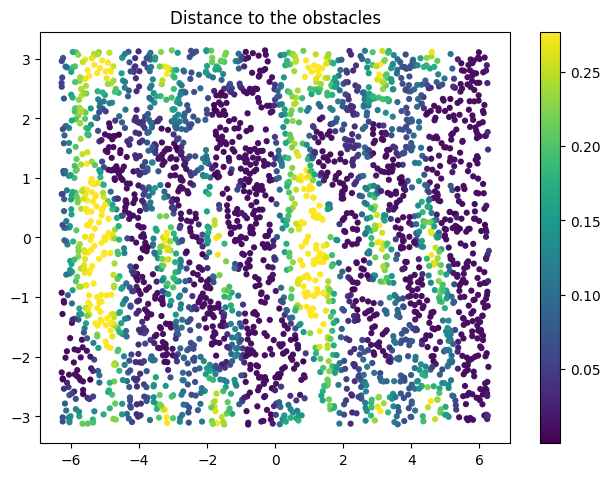

In [17]:
distance_data = np.load("./tp7/distance_data.npy")

def plotConfigurationSpace(data,markerSize=20):
     plt.subplot(1,1,1)
     plt.scatter(data[:,0],data[:,1],c=data[:,2],s=markerSize,lw=0)
     plt.title("Distance to the obstacles")
     plt.colorbar()
     plt.tight_layout(pad=0.8)

plotConfigurationSpace(distance_data)

What we are going to do now is to try to approximate  $\mathcal{C}_{free}$ with a union of polytope.  
For this we will use support vector machine to solve a classification problem. You do not really need to understand the following process for the assessed part of ARO, but you may be interested in the process in general so I ll share it here.

First, let us convert the distance measure into 0/1 values to have a binary distribution between colliding configurations and collision free ones.




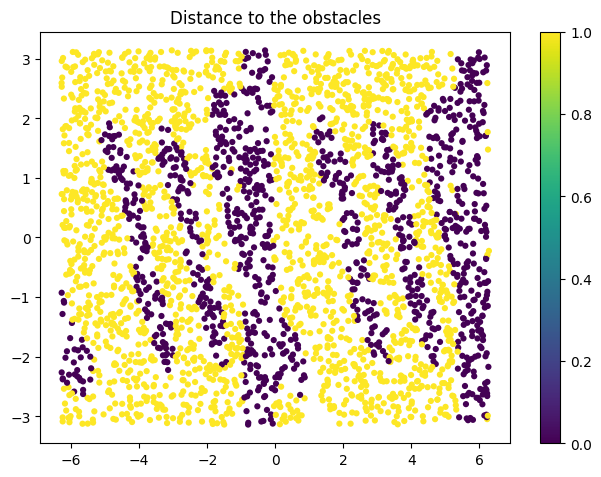

In [18]:
data_bin = np.array([[el[0], el[1], 0. if el[2] < 0.03 else 1.] for el in distance_data])

plotConfigurationSpace(data_bin)

We'll also "shift" the data on the second axis to make sure we cover the continuity from 

In [31]:
B = np.array([[el[0], el[1]]  for el in distance_data if el[2] < 0.03  ])
B.shape

(1077, 2)

The following code will work if sciki-learn is installed. If not, you can ignore this cell and directly run the next one where the polytopes have been saved for you.

Generation 0: Best fitness = -13488.466359978738
Generation 1: Best fitness = -13488.466359978738
Generation 2: Best fitness = -11102.093767525455
Generation 3: Best fitness = -11102.093767525455
Generation 4: Best fitness = -9313.072115713028
Generation 5: Best fitness = -8806.658876296546
Generation 6: Best fitness = -8416.33020521925
Generation 7: Best fitness = -8123.181908340833
Generation 8: Best fitness = -6326.493351158059
Generation 9: Best fitness = -6227.9744410497315
Generation 10: Best fitness = -6131.318978263323
Generation 11: Best fitness = -6032.800068154994
Generation 12: Best fitness = -5441.848219729494
Generation 13: Best fitness = -5441.848219729494
Generation 14: Best fitness = -5441.848219729494
Generation 15: Best fitness = -5048.104576417699
Generation 16: Best fitness = -4851.207767834419
Generation 17: Best fitness = -4847.265856536256
Generation 18: Best fitness = -4847.265856536256
Generation 19: Best fitness = -4847.265856536256
Generation 20: Best fitnes

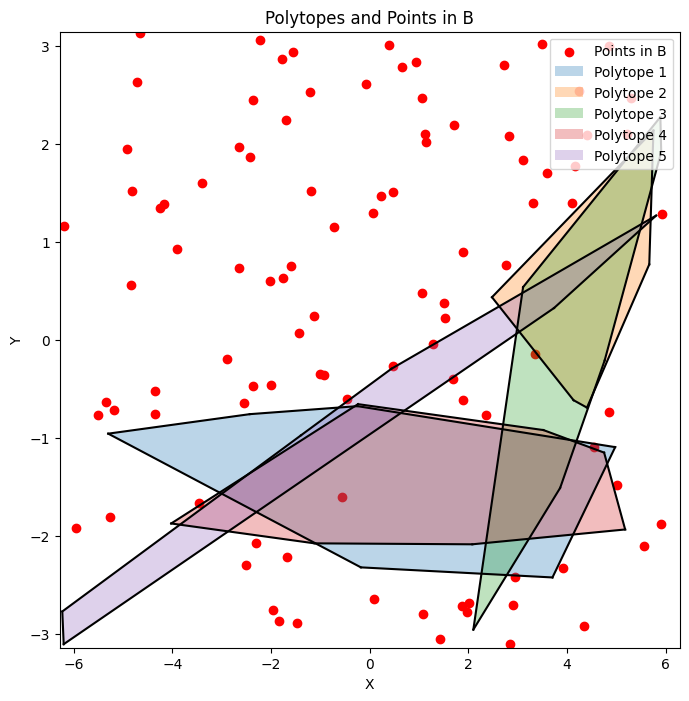

In [23]:
import numpy as np
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from math import pi

# Parameters
xmin, xmax = -2*pi, 2*pi
ymin, ymax = -pi, pi
bounds = [(xmin, xmax), (ymin, ymax)]  # Define bounds for the 2D space
n_polytopes = 5  # Number of polytopes
n_points_per_polytope = 8
penalty_factor = 100  # Large penalty for points in B inside any polytope
population_size = 50
generations = 200
mutation_rate = 0.1


def random_solution():
    """Generate a random solution (set of polytopes) within bounds."""
    return np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=(n_polytopes, n_points_per_polytope, 2))

def convex_hull_area(points):
    """Calculate the area of the convex hull formed by a set of points."""
    if len(points) < 3:
        return 0
    hull = ConvexHull(points)
    return hull.volume  # 2D area is the volume for ConvexHull

def is_point_in_polytope(point, polytope_points):
    """Check if a point is inside the convex hull of a polytope."""
    hull = ConvexHull(polytope_points)
    new_points = np.vstack([polytope_points, point])
    try:
        new_hull = ConvexHull(new_points)
        return np.array_equal(hull.vertices, new_hull.vertices)
    except:
        return False

def fitness(solution):
    """Calculate the fitness of a solution."""
    total_area = 0
    penalty = 0
    
    for polytope in solution:
        hull_area = convex_hull_area(polytope)
        total_area += hull_area
        
        # Apply penalty for any point in B inside the polytope
        for b_point in B:
            if is_point_in_polytope(b_point, polytope):
                penalty += penalty_factor

    return total_area - penalty

def crossover(parent1, parent2):
    """Perform crossover between two parent solutions."""
    crossover_point = random.randint(1, n_polytopes - 1)
    child1 = np.vstack([parent1[:crossover_point], parent2[crossover_point:]])
    child2 = np.vstack([parent2[:crossover_point], parent1[crossover_point:]])
    return child1, child2

def mutate(solution):
    """Mutate a solution by moving a random point."""
    for i in range(n_polytopes):
        if random.random() < mutation_rate:
            poly_idx = random.randint(0, n_polytopes - 1)
            point_idx = random.randint(0, n_points_per_polytope - 1)
            solution[poly_idx][point_idx] = np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=2)
    return solution

def genetic_algorithm(initial_guess=None):
    # Initialize population
    population = initial_guess
    if population is None:
        population = [random_solution() for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness
        population_fitness = [(solution, fitness(solution)) for solution in population]
        population_fitness.sort(key=lambda x: x[1], reverse=True)

        # Select the best solutions (elitism)
        new_population = [solution for solution, _ in population_fitness[:population_size//2]]

        # Generate new offspring via crossover and mutation
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(new_population[:population_size//4], 2)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1))
            new_population.append(mutate(child2))

        population = new_population

        # Track progress
        best_fitness = population_fitness[0][1]
        print(f'Generation {generation}: Best fitness = {best_fitness}')

    # Return the best solution
    return population_fitness[0][0]

def plot_polytopes_and_B(solution, B):
    """Plot the polytopes and the points in B."""
    plt.figure(figsize=(8, 8))
    
    # Plot points in B
    plt.scatter(B[:, 0], B[:, 1], color='red', label='Points in B')

    # Plot each polytope
    for i, polytope in enumerate(solution):
        hull = ConvexHull(polytope)
        for simplex in hull.simplices:
            plt.plot(polytope[simplex, 0], polytope[simplex, 1], 'k-')
        
        # Fill the polytope for visualization
        plt.fill(polytope[hull.vertices, 0], polytope[hull.vertices, 1], alpha=0.3, label=f'Polytope {i+1}')

    # Set plot bounds
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Polytopes and Points in B')
    plt.legend(loc='upper right')
    plt.show()

# Execute the genetic algorithm
best_solution = genetic_algorithm(best_solution)
print("Best solution found:", best_solution)

# Plot the best solution along with points in B
plot_polytopes_and_B(best_solution, B)


Generation 0: Best fitness = -1488.8049580521317
Generation 1: Best fitness = -1488.8049580521317
Generation 2: Best fitness = -1488.8049580521317
Generation 3: Best fitness = -1488.8049580521317
Generation 4: Best fitness = -1488.8049580521317
Generation 5: Best fitness = -1488.8049580521317
Generation 6: Best fitness = -1488.8049580521317
Generation 7: Best fitness = -1488.7165434247827
Generation 8: Best fitness = -1488.7165434247827
Generation 9: Best fitness = -1488.7165434247827
Generation 10: Best fitness = -1488.7165434247827
Generation 11: Best fitness = -1488.7165434247827
Generation 12: Best fitness = -1488.7165434247827
Generation 13: Best fitness = -1488.7165434247827
Generation 14: Best fitness = -1488.7165434247827
Generation 15: Best fitness = -1488.7165434247827
Generation 16: Best fitness = -1488.70874811253
Generation 17: Best fitness = -1388.7347288129738
Generation 18: Best fitness = -1388.7347288129738
Generation 19: Best fitness = -1388.7347288129738
Generation 2

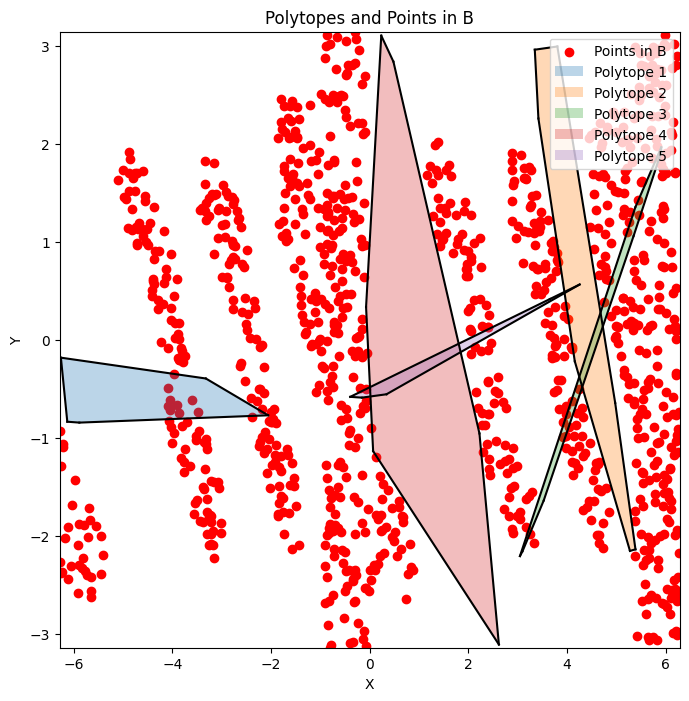

In [32]:
import numpy as np
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from math import pi

# Parameters
xmin, xmax = -2*pi, 2*pi
ymin, ymax = -pi, pi
bounds = [(xmin, xmax), (ymin, ymax)]  # Define bounds for the 2D space
n_polytopes = 5  # Number of polytopes
n_points_per_polytope = 8
penalty_factor = 100  # Large penalty for points in B inside any polytope
population_size = 50
generations = 200
mutation_rate = 0.1


def random_solution():
    """Generate a random solution (set of polytopes) within bounds."""
    return np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=(n_polytopes, n_points_per_polytope, 2))

def convex_hull_area(points):
    """Calculate the area of the convex hull formed by a set of points."""
    if len(points) < 3:
        return 0
    hull = ConvexHull(points)
    return hull.volume  # 2D area is the volume for ConvexHull

def is_point_in_polytope(point, polytope_points):
    """Check if a point is inside the convex hull of a polytope."""
    hull = ConvexHull(polytope_points)
    new_points = np.vstack([polytope_points, point])
    try:
        new_hull = ConvexHull(new_points)
        return np.array_equal(hull.vertices, new_hull.vertices)
    except:
        return False

def fitness(solution):
    """Calculate the fitness of a solution."""
    total_area = 0
    penalty = 0
    
    for polytope in solution:
        hull_area = convex_hull_area(polytope)
        total_area += hull_area
        
        # Apply penalty for any point in B inside the polytope
        for b_point in B:
            if is_point_in_polytope(b_point, polytope):
                penalty += penalty_factor

    return total_area - penalty

def crossover(parent1, parent2):
    """Perform crossover between two parent solutions."""
    crossover_point = random.randint(1, n_polytopes - 1)
    child1 = np.vstack([parent1[:crossover_point], parent2[crossover_point:]])
    child2 = np.vstack([parent2[:crossover_point], parent1[crossover_point:]])
    return child1, child2

def mutate(solution):
    """Mutate a solution by moving a random point."""
    for i in range(n_polytopes):
        if random.random() < mutation_rate:
            poly_idx = random.randint(0, n_polytopes - 1)
            point_idx = random.randint(0, n_points_per_polytope - 1)
            solution[poly_idx][point_idx] = np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=2)
    return solution

def genetic_algorithm(initial_guess=None):
    # Initialize population
    population = [random_solution() for _ in range(population_size)]
    if initial_guess is not None:
        population += [initial_guess]

    for generation in range(generations):
        # Evaluate fitness
        population_fitness = [(solution, fitness(solution)) for solution in population]
        population_fitness.sort(key=lambda x: x[1], reverse=True)

        # Select the best solutions (elitism)
        new_population = [solution for solution, _ in population_fitness[:population_size//2]]

        # Generate new offspring via crossover and mutation
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(new_population[:population_size//4], 2)
            child1, child2 = crossover(parent1, parent2)
            new_population.append(mutate(child1))
            new_population.append(mutate(child2))

        population = new_population

        # Track progress
        best_fitness = population_fitness[0][1]
        print(f'Generation {generation}: Best fitness = {best_fitness}')

    # Return the best solution
    return population_fitness[0][0]

def plot_polytopes_and_B(solution, B):
    """Plot the polytopes and the points in B."""
    plt.figure(figsize=(8, 8))
    
    # Plot points in B
    plt.scatter(B[:, 0], B[:, 1], color='red', label='Points in B')

    # Plot each polytope
    for i, polytope in enumerate(solution):
        hull = ConvexHull(polytope)
        for simplex in hull.simplices:
            plt.plot(polytope[simplex, 0], polytope[simplex, 1], 'k-')
        
        # Fill the polytope for visualization
        plt.fill(polytope[hull.vertices, 0], polytope[hull.vertices, 1], alpha=0.3, label=f'Polytope {i+1}')

    # Set plot bounds
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Polytopes and Points in B')
    plt.legend(loc='upper right')
    plt.show()

# Execute the genetic algorithm
best_solution = genetic_algorithm(best_solution)
print("Best solution found:", best_solution)

# Plot the best solution along with points in B
plot_polytopes_and_B(best_solution, B)


In [22]:
import numpy as np
from scipy.spatial import ConvexHull
import cma
import matplotlib.pyplot as plt
from math import pi

# Parameters
xmin, xmax = -2*pi, 2*pi
ymin, ymax = -pi, pi
n_polytopes = 5  # Number of polytopes
n_points_per_polytope = 8
penalty_factor = 1e6  # Large penalty for points in B inside any polytope

# Example dataset B (points to avoid being inside polytopes)
B = np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=(100, 2))

def convex_hull_area(points):
    """Calculate the area of the convex hull formed by a set of points."""
    if len(points) < 3:
        return 0
    hull = ConvexHull(points)
    return hull.volume  # 2D area is the volume for ConvexHull

def is_point_in_polytope(point, polytope_points):
    """Check if a point is inside the convex hull of a polytope."""
    hull = ConvexHull(polytope_points)
    new_points = np.vstack([polytope_points, point])
    try:
        new_hull = ConvexHull(new_points)
        return np.array_equal(hull.vertices, new_hull.vertices)
    except:
        return False

def fitness(flat_solution):
    """Calculate the fitness of a solution."""
    # Reshape the flat solution into the structure (n_polytopes, n_points_per_polytope, 2)
    solution = flat_solution.reshape((n_polytopes, n_points_per_polytope, 2))
    
    total_area = 0
    penalty = 0
    
    for polytope in solution:
        hull_area = convex_hull_area(polytope)
        total_area += hull_area
        
        # Apply penalty for any point in B inside the polytope
        for b_point in B:
            if is_point_in_polytope(b_point, polytope):
                penalty += penalty_factor

    return -(total_area - penalty)  # CMA-ES minimizes, so we negate the fitness

def plot_polytopes_and_B(solution, B):
    """Plot the polytopes and the points in B."""
    plt.figure(figsize=(8, 8))
    
    # Plot points in B
    plt.scatter(B[:, 0], B[:, 1], color='red', label='Points in B')

    # Plot each polytope
    for i, polytope in enumerate(solution):
        hull = ConvexHull(polytope)
        for simplex in hull.simplices:
            plt.plot(polytope[simplex, 0], polytope[simplex, 1], 'k-')
        
        # Fill the polytope for visualization
        plt.fill(polytope[hull.vertices, 0], polytope[hull.vertices, 1], alpha=0.3, label=f'Polytope {i+1}')

    # Set plot bounds
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Polytopes and Points in B')
    plt.legend(loc='upper right')
    plt.show()

# Define the initial solution and run CMA-ES
initial_solution = np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=(n_polytopes * n_points_per_polytope * 2))

# Set standard deviation for CMA-ES
sigma = 0.5

# Run the CMA-ES algorithm
es = cma.CMAEvolutionStrategy(initial_solution, sigma)
es.optimize(fitness)

# Get the best solution found by CMA-ES
best_solution_flat = es.result.xbest
best_solution = best_solution_flat.reshape((n_polytopes, n_points_per_polytope, 2))

# Plot the best solution along with points in B
plot_polytopes_and_B(best_solution, B)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (80,) and arg 1 with shape (2,).